In [14]:
# Import libraries
import matplotlib.pyplot as plt
import json
from PIL import Image
import numpy as np
import os
import cv2
import imantics
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [15]:
# Load the data (same as in data_exploration.ipynb)

# Load the dataset annotations
with open('../data/annotations/instances_default.json') as f:
    dataset_annotations = json.load(f)

# Create a mapping between image IDs and filenames
image_id_to_filename = {}
for image in dataset_annotations['images']:
    image_id_to_filename[image['id']] = image['file_name']

# Define the image size
resized_image_size = 256
input_image_size = (1920, 1080)

# Define the number of images in the dataset
n_images = len(dataset_annotations['images'])

# Load the images and masks into NumPy arrays
images = np.zeros((n_images, resized_image_size, resized_image_size, 3), dtype=np.uint8)
masks = np.zeros((n_images, resized_image_size, resized_image_size), dtype=bool)

for image_id, image_filename in image_id_to_filename.items():
    # Load the image and resize it
    image_path = f"/Users/jules/Documents/Devs/Player_segmentation/data/images/{image_filename}"
    actual_img = cv2.imread(image_path)
    actual_img = cv2.cvtColor(actual_img, cv2.COLOR_BGR2RGB)
    actual_img = cv2.resize(actual_img, (resized_image_size, resized_image_size))

    # Store the image in the images array
    images[image_id - 1] = actual_img

    # Load the mask and resize it
    for annotation in dataset_annotations['annotations']:
        if annotation['image_id'] == image_id:
            segmentation = annotation['segmentation']
            actual_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
            actual_mask = cv2.resize(actual_mask.astype(float), (resized_image_size, resized_image_size)) >= 0.5

            # Combine masks from different annotations into a single mask for each image
            masks[image_id - 1] = masks[image_id - 1] | actual_mask


In [16]:
# Split the data into training, validation and test sets
train_val_images, test_images, train_val_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_val_images, train_val_masks, test_size=0.2, random_state=42)

In [17]:
import segmentation_models as sm

# Choose the model backbone
BACKBONE = 'resnet34'

# Preprocess input as the model expects
preprocess_input = sm.get_preprocessing(BACKBONE)

In [18]:
# Preprocess the data
train_images_preprocessed = preprocess_input(train_images)
val_images_preprocessed = preprocess_input(val_images)
test_images_preprocessed = preprocess_input(test_images)

In [19]:
# Define the model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()])

In [21]:
# Train the model
history = model.fit(train_images_preprocessed, train_masks, validation_data=(val_images_preprocessed, val_masks), epochs=10, batch_size=8)

Epoch 1/10
41/41 [==============================] - 312s 7s/step - loss: 0.1704 - iou_score: 0.0793 - f1-score: 0.1432 - val_loss: 0.3126 - val_iou_score: 0.0099 - val_f1-score: 0.0195
Epoch 2/10
41/41 [==============================] - 193s 5s/step - loss: 0.0447 - iou_score: 0.2627 - f1-score: 0.4138 - val_loss: 0.1177 - val_iou_score: 0.0612 - val_f1-score: 0.1153
Epoch 3/10
41/41 [==============================] - 194s 5s/step - loss: 0.0262 - iou_score: 0.4025 - f1-score: 0.5732 - val_loss: 0.0626 - val_iou_score: 0.1121 - val_f1-score: 0.2015
Epoch 4/10
41/41 [==============================] - 192s 5s/step - loss: 0.0197 - iou_score: 0.4916 - f1-score: 0.6587 - val_loss: 0.0414 - val_iou_score: 0.1991 - val_f1-score: 0.3319
Epoch 5/10
41/41 [==============================] - 196s 5s/step - loss: 0.0160 - iou_score: 0.5576 - f1-score: 0.7158 - val_loss: 0.0300 - val_iou_score: 0.3105 - val_f1-score: 0.4736
Epoch 6/10
41/41 [==============================] - 187s 5s/step - loss: 0.

In [22]:
# Extract the training and validation loss and metrics (accuracy or other metrics) from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
#train_accuracy = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']
train_iou_score = history.history['iou_score']
val_iou_score = history.history['val_iou_score']
train_f1_score = history.history['f1-score']
val_f1_score = history.history['val_f1-score']

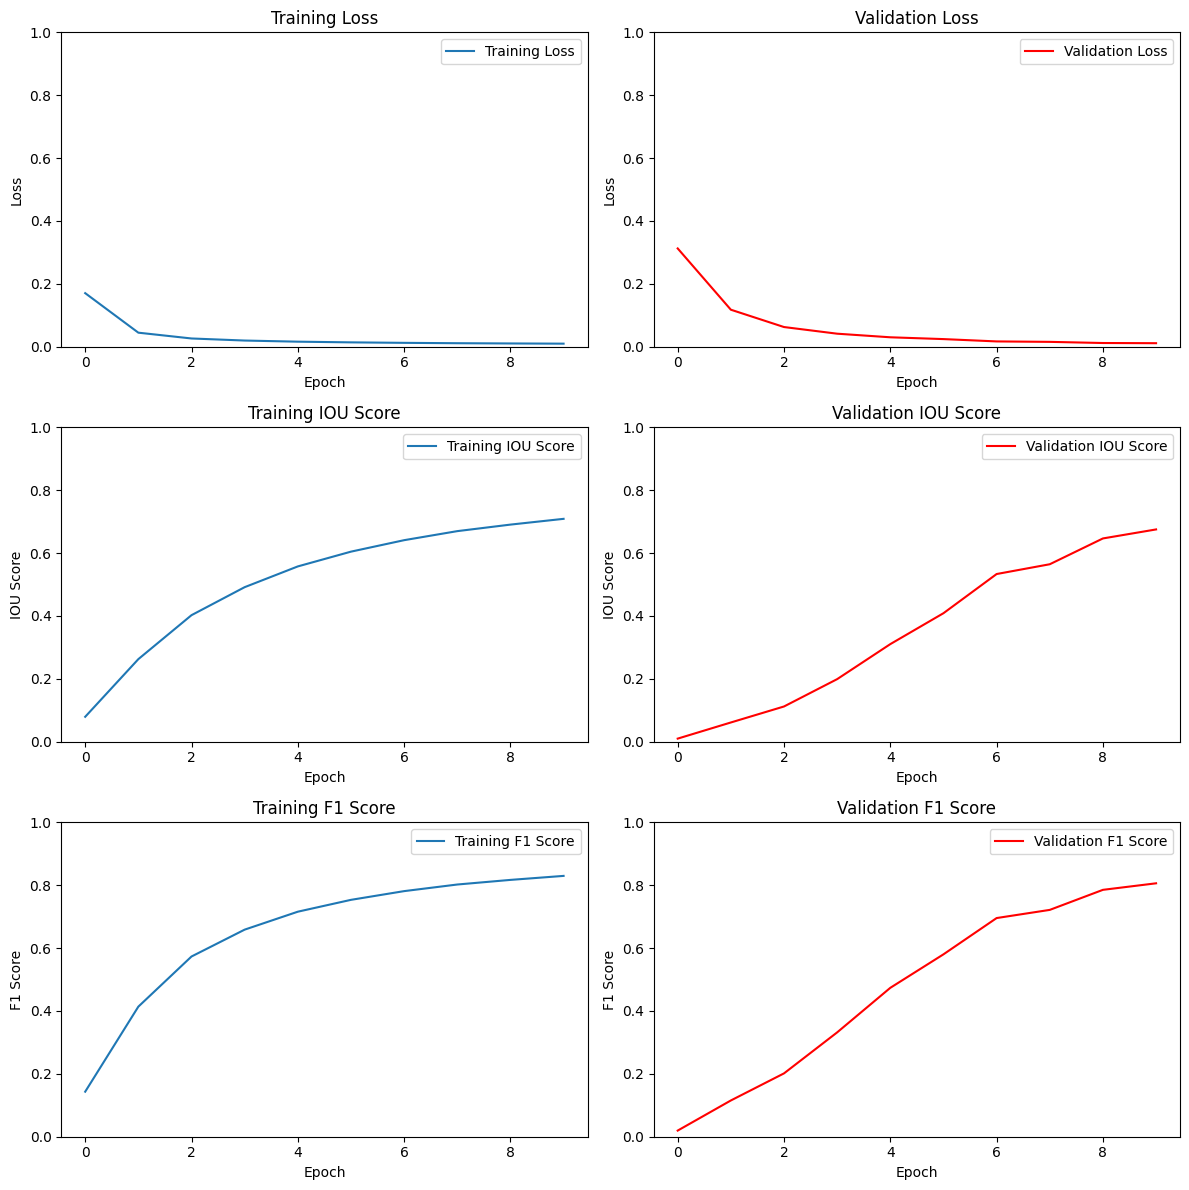

In [23]:
# Plot the training, validation loss and training, validation accuracy
fig, axes = plt.subplots(3, 2, figsize=(12, 12))#, sharey='row')

# set y axis limits
axes[0, 0].set_ylim([0, 1])
axes[0, 1].set_ylim([0, 1])
axes[1, 0].set_ylim([0, 1])
axes[1, 1].set_ylim([0, 1])
axes[2, 0].set_ylim([0, 1])
axes[2, 1].set_ylim([0, 1])

# Plot the training loss
axes[0, 0].plot(history.epoch, train_loss, label='Training Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot the validation loss
axes[0, 1].plot(history.epoch, val_loss, 'r', label='Validation Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Plot the training IOU score
axes[1, 0].plot(history.epoch, train_iou_score, label='Training IOU Score')
axes[1, 0].set_title('Training IOU Score')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IOU Score')
axes[1, 0].legend()

# Plot the validation IOU score
axes[1, 1].plot(val_iou_score, 'r', label='Validation IOU Score')
axes[1, 1].set_title('Validation IOU Score')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('IOU Score')
axes[1, 1].legend()

# Plot the training F1 score
axes[2, 0].plot(train_f1_score, label='Training F1 Score')
axes[2, 0].set_title('Training F1 Score')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('F1 Score')
axes[2, 0].legend()

# Plot the validation F1 score
axes[2, 1].plot(val_f1_score, 'r', label='Validation F1 Score')
axes[2, 1].set_title('Validation F1 Score')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('F1 Score')
axes[2, 1].legend()

# # Plot the training accuracy
# axes[1, 0].plot(train_accuracy, label='Training Accuracy')
# axes[1, 0].set_title('Training Accuracy')
# axes[1, 0].set_xlabel('Epoch')
# axes[1, 0].set_ylabel('Accuracy')
# axes[1, 0].legend()

# # Plot the validation accuracy
# axes[1, 1].plot(val_accuracy, label='Validation Accuracy')
# axes[1, 1].set_title('Validation Accuracy')
# axes[1, 1].set_xlabel('Epoch')
# axes[1, 1].set_ylabel('Accuracy')
# axes[1, 1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [24]:
# Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(test_images_preprocessed, test_masks, verbose=2)

test_loss, test_iou_score, test_f1_score = model.evaluate(test_images_preprocessed, test_masks, verbose=2)

# Print the test loss and accuracy
# print(f'Test accuracy: {test_accuracy}')
#print(f'Test loss: {test_loss}')
print(f'Test IOU score: {test_iou_score}')
print(f'Test F1 score: {test_f1_score}')


4/4 - 14s - loss: 0.0112 - iou_score: 0.6787 - f1-score: 0.8085 - 14s/epoch - 4s/step
Test IOU score: 0.6786717176437378
Test F1 score: 0.8085172772407532


4/4 [==============================] - 15s 3s/step


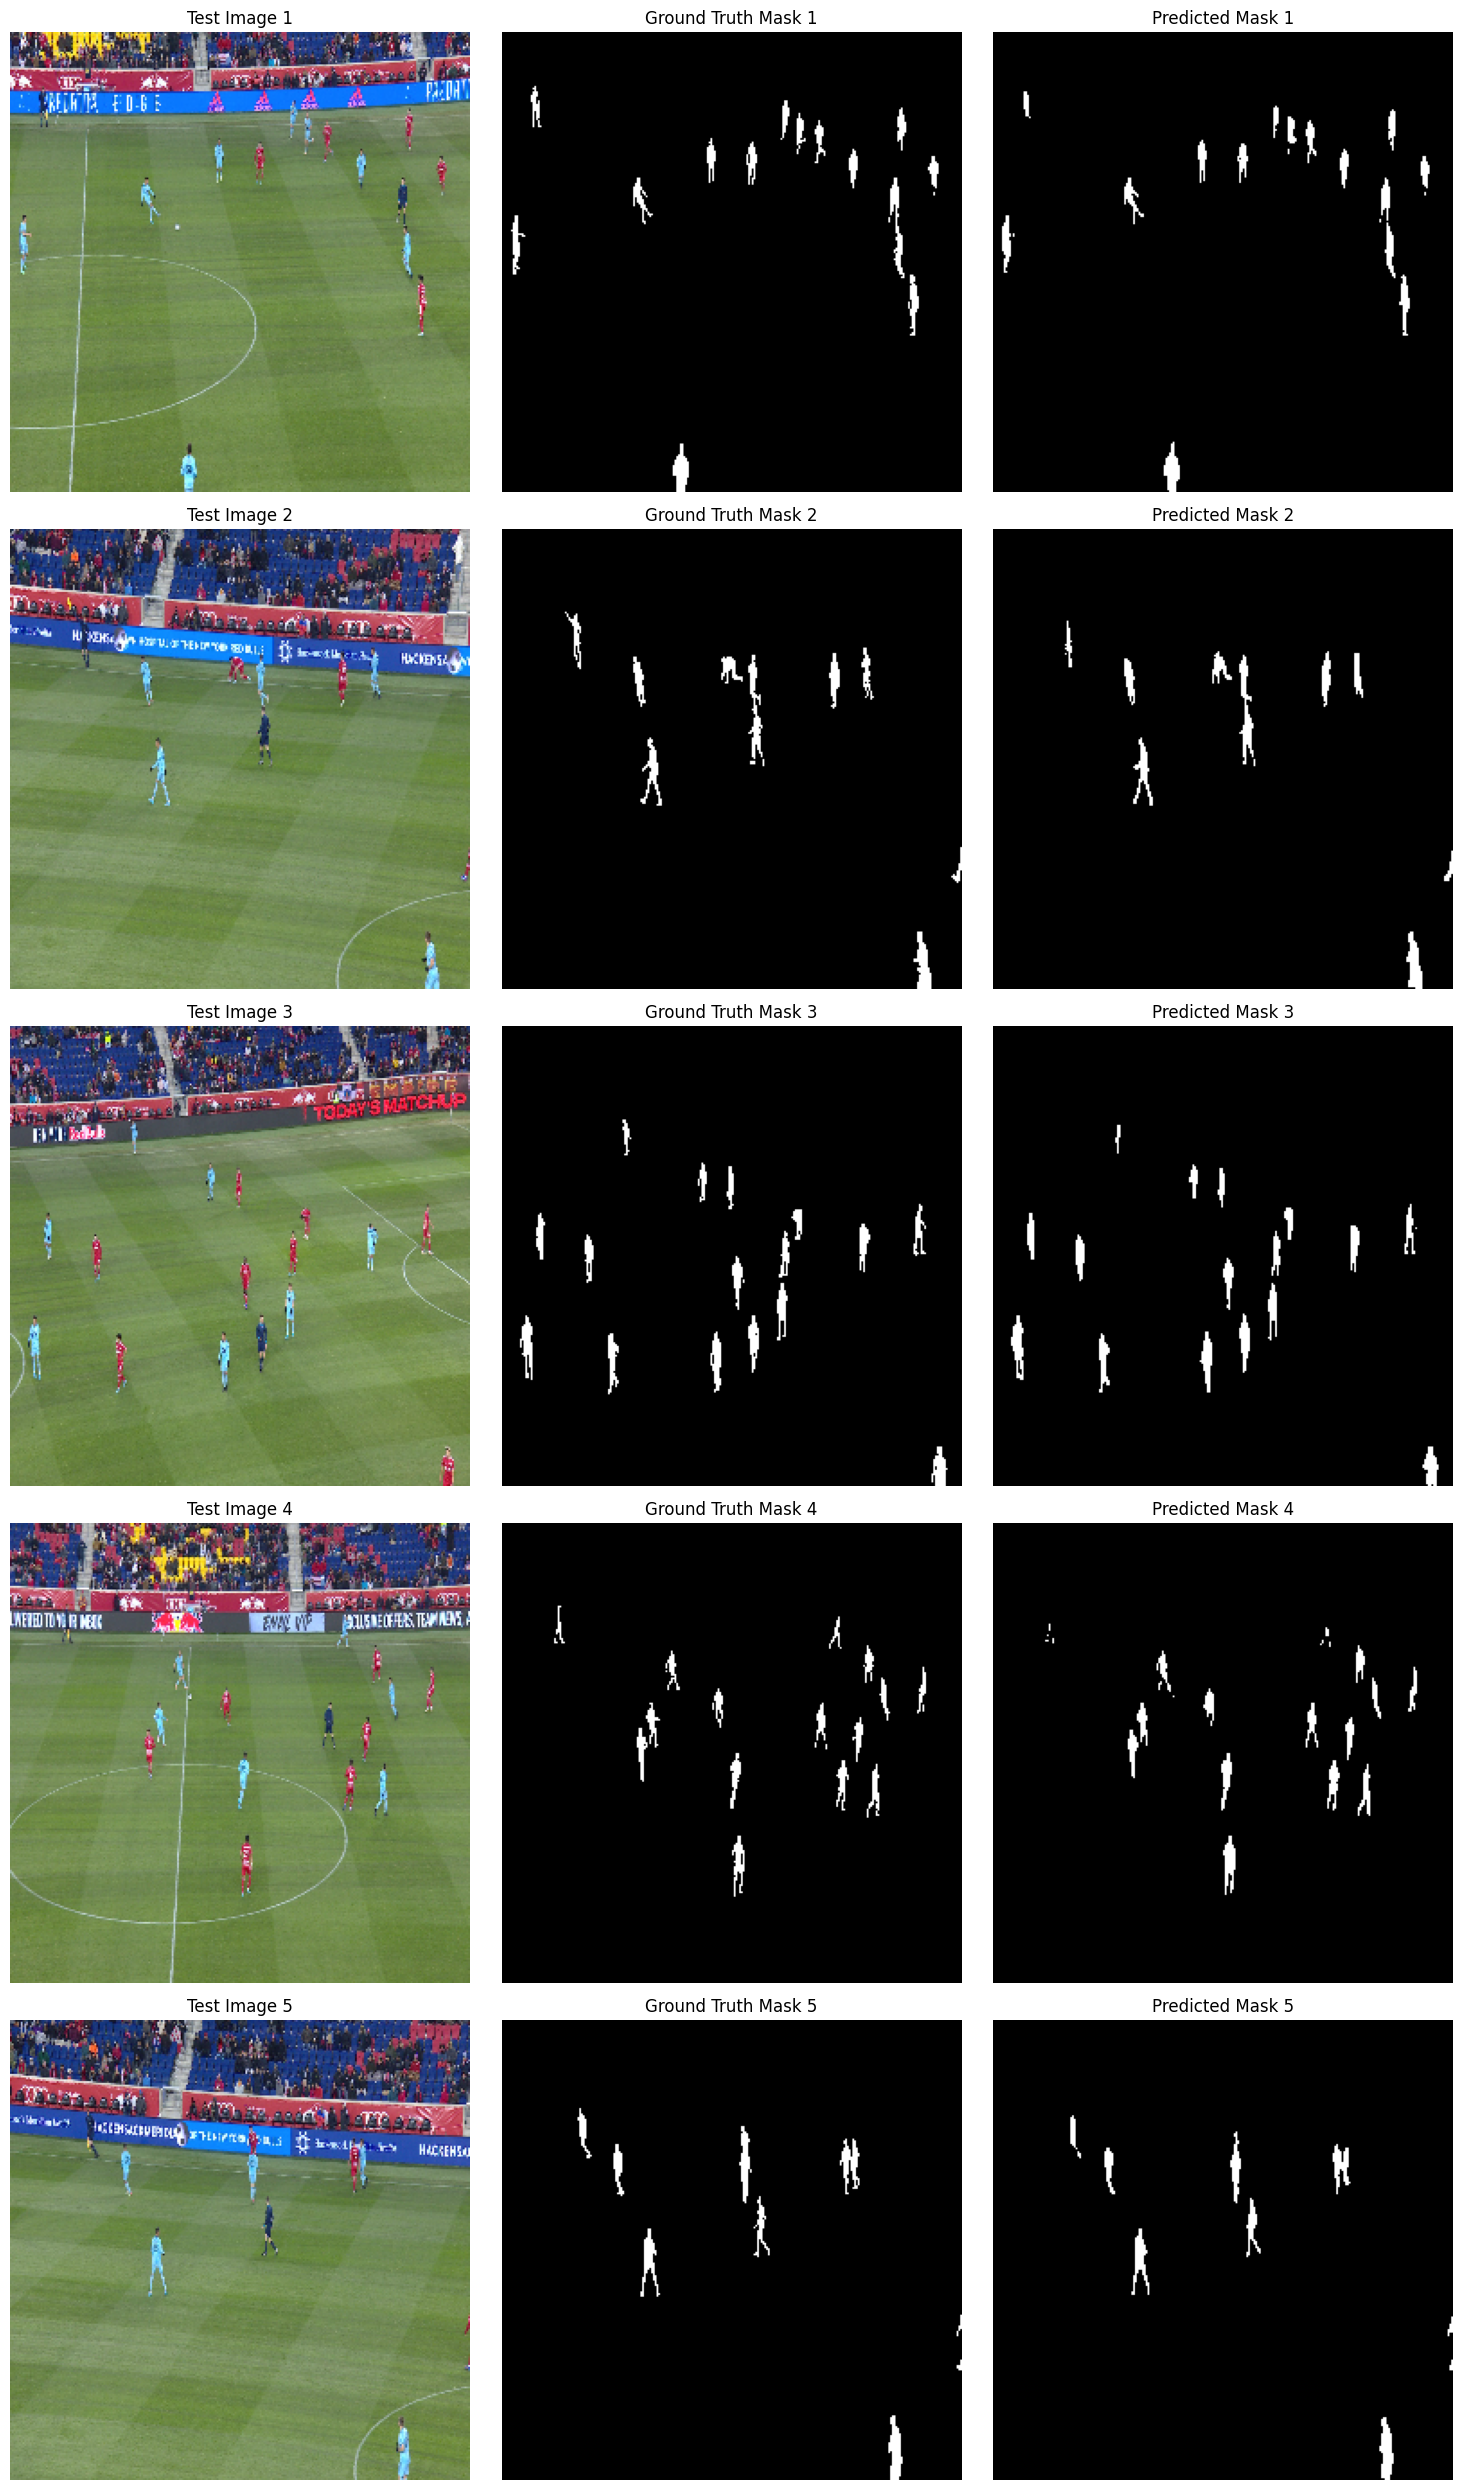

In [25]:
# Make predictions on the test set
predictions = model.predict(test_images_preprocessed)

# Define the number of images to display
n_images_to_show = 5

# Display the images, masks and predictions
fig, axes = plt.subplots(n_images_to_show, 3, figsize=(15, n_images_to_show * 5))

for i in range(n_images_to_show):
    # Display the test image
    axes[i, 0].imshow(test_images[i])
    axes[i, 0].set_title(f"Test Image {i + 1}")
    axes[i, 0].axis('off')

    # Display the ground truth mask
    axes[i, 1].imshow(test_masks[i].squeeze(), cmap='gray')
    axes[i, 1].set_title(f"Ground Truth Mask {i + 1}")
    axes[i, 1].axis('off')

    # Display the predicted mask
    axes[i, 2].imshow(predictions[i].squeeze() > 0.5, cmap='gray')
    axes[i, 2].set_title(f"Predicted Mask {i + 1}")
    axes[i, 2].axis('off')

# Show the plots
plt.tight_layout()
plt.show()